In [59]:
import pandas as pd

data = pd.read_excel("/content/Horizontal_Format.xlsx")

data.head()


,TiD,items
0,1,"M,O,N,K,E,Y"
1,2,"D,O,N,K,E,Y"
2,3,"M,A,K,E"
3,4,"M,U,C,K,Y"
4,5,"C,O,O,K,I,E"


In [60]:
# Convert the 'items' column to a list of sets, each representing a transaction

transactions = []
for item in data['items']:
    trans_set = set(item.split(','))
    transactions.append(trans_set)
transactions[0:5]

[{'E', 'K', 'M', 'N', 'O', 'Y'},
 {'D', 'E', 'K', 'N', 'O', 'Y'},
 {'A', 'E', 'K', 'M'},
 {'C', 'K', 'M', 'U', 'Y'},
 {'C', 'E', 'I', 'K', 'O'}]

In [74]:

def makeCandidates(itemsets, k):

    #will give me itemsets of the same size
    candidates = set()
    itemsets_list = list(itemsets)

    is_one_item = 0 #bool

    if(len(itemsets_list[0]) == 1):
      is_one_item = 1

    for i in range(len(itemsets_list)):
        for j in range(i + 1, len(itemsets_list)):
            #to be able to compare its elements -> convert to list
            itemset1 = list(itemsets_list[i])
            itemset2 = list(itemsets_list[j])


            if is_one_item:
              #if it's one item union easly
              candidate = itemsets_list[i].union(itemsets_list[j])
              if len(candidate) == k:
                candidates.add(candidate)
            else:
              is_equal = 1
              #else check if first k-1 items are equal then union
              for n in range(len(itemset1)-1):
                if itemset1[n] != itemset2[n]:
                  is_equal = 0
                  break

              if is_equal:
                candidate = itemsets_list[i].union(itemsets_list[j])
                if len(candidate) == k:
                    candidates.add(candidate)

    return candidates

In [75]:


def calcSupport(transactions, candidates):

    support = {}
    for transaction in transactions:
        for candidate in candidates:
            if candidate.issubset(transaction):
              if candidate not in support:
                  support[candidate] = 0
              support[candidate] += 1

    # Convert support counts to support persentage
    new_support = {}
    for itemset, count in support.items():
        new_support[itemset] = count / len(transactions)
    return new_support

# Define a minimum support threshold
min_support = 0.6

# Step 3: Generate frequent itemsets iteratively

def apriori(transactions, min_support):

    # Initialize variables
    k = 1
    frequent_itemsets = {}

    # Generate initial single-item candidates
    currItemsets = set()
    for transaction in transactions:
        for item in transaction:
          currItemsets.add(frozenset([item]))#to be able to put it as a key , and do operations on it like union and issubstet

    # Iteratively generate frequent itemsets of increasing size
    while currItemsets:
        # Calculate support for current itemsets
        support = calcSupport(transactions, currItemsets)

        # Filter itemsets by minimum support
        for itemset, support in support.items():
            if support >= min_support:
                frequent_itemsets[itemset] = support

        # Generate candidates for the next level
        currItemsets = makeCandidates(frequent_itemsets.keys(), k + 1)

        # Increment k to generate the next level of itemsets
        k += 1

    return frequent_itemsets

# Run the Apriori algorithm on our dataset
frequent_itemsets = apriori(transactions, min_support)

# Display the frequent itemsets and their support values
frequent_itemsets


{frozenset({'Y'}): 0.6,
 frozenset({'M'}): 0.6,
 frozenset({'K'}): 1.0,
 frozenset({'O'}): 0.6,
 frozenset({'E'}): 0.8,
 frozenset({'K', 'Y'}): 0.6,
 frozenset({'E', 'K'}): 0.8,
 frozenset({'E', 'O'}): 0.6,
 frozenset({'K', 'O'}): 0.6,
 frozenset({'K', 'M'}): 0.6,
 frozenset({'E', 'K', 'O'}): 0.6}

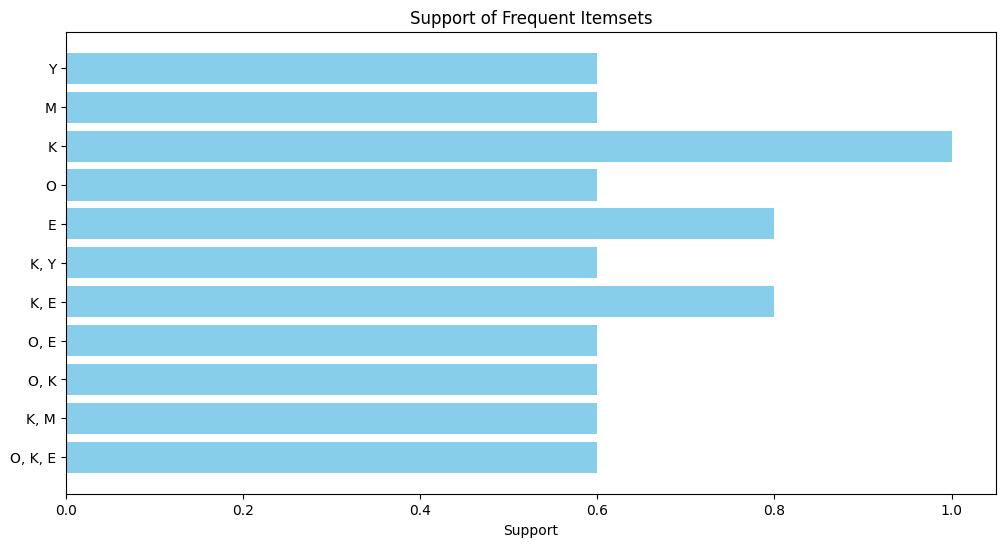

In [76]:
import matplotlib.pyplot as plt

# Convert the frequent itemsets dictionary to a DataFrame for easier plotting
frequent_itemsets_df = pd.DataFrame(list(frequent_itemsets.items()), columns=['Itemset', 'Support'])
frequent_itemsets_df['Itemset'] = frequent_itemsets_df['Itemset'].apply(lambda x: ', '.join(x))

# Plot a bar chart of frequent itemsets' support values
plt.figure(figsize=(12, 6))
plt.barh(frequent_itemsets_df['Itemset'], frequent_itemsets_df['Support'], color='skyblue')
plt.xlabel('Support')
plt.title('Support of Frequent Itemsets')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [77]:

def all_associationRules(frequent_itemsets, min_confidence,transactions):

    rules = []
    num_transactions = len(transactions)
    # Iterate through each frequent itemset
    for itemset, itemset_support in frequent_itemsets.items():
      # Generate all non-empty subsets of the itemset
      for item in itemset:
        first = frozenset(itemset - {item})#frozen because we will use it as a key
        second = frozenset({item})

        # Calculate confidence
        if first in frequent_itemsets:
          #if condition because if it was 1-itemset ,then first will be nothing
          confidence = itemset_support / frequent_itemsets[first]

          # lift
          lift = calc_lift(itemset_support,first,second,frequent_itemsets,transactions)
          # successful rule
          first_rule = (first,second, confidence, lift)
          if first_rule not in rules:
            rules.append((first, second, confidence, lift))


        #switch
        # first = frozenset({item})
        # second = frozenset(itemset - {item})
        tmp = first
        first = second
        second = tmp

        # Calculate confidence
        if first in frequent_itemsets and second in frequent_itemsets:
          #if condition because if it was 1-itemset ,then first will be nothing
          confidence = itemset_support / frequent_itemsets[first]

          # lift
          lift = calc_lift(itemset_support,first,second,frequent_itemsets,transactions)
          # successful rule
          second_rule = (first,second, confidence, lift)
          if second_rule not in rules:
            rules.append((first, second, confidence, lift))

    return rules

def associationRules(frequent_itemsets, min_confidence,transactions):

    rules = []
    num_transactions = len(transactions)
    # Iterate through each frequent itemset
    for itemset, itemset_support in frequent_itemsets.items():
      # Generate all non-empty subsets of the itemset
      for item in itemset:
        first = frozenset(itemset - {item})#frozen because we will use it as a key
        second = frozenset({item})

        # Calculate confidence
        if first in frequent_itemsets:
          #if condition because if it was 1-itemset ,then first will be nothing
          confidence = itemset_support / frequent_itemsets[first]

          # Only  rules with min confidence
          if confidence >= min_confidence:
              # lift
              lift = calc_lift(itemset_support,first,second,frequent_itemsets,transactions)
              # successful rule
              first_rule = (first,second, confidence, lift)
              if first_rule not in rules:
                rules.append((first, second, confidence, lift))

        #switch
        # first = frozenset({item})
        # second = frozenset(itemset - {item})
        tmp = first
        first = second
        second = tmp

        # Calculate confidence
        if first in frequent_itemsets and second in frequent_itemsets:
          #if condition because if it was 1-itemset ,then first will be nothing
          confidence = itemset_support / frequent_itemsets[first]

          # Only  rules with min confidence
          if confidence >= min_confidence:
              # lift
              lift = calc_lift(itemset_support,first,second,frequent_itemsets,transactions)
              # successful rule
              second_rule = (first,second, confidence, lift)
              if second_rule not in rules:
                rules.append((first, second, confidence, lift))

    return rules

def calc_lift(itemset_support,first,second,frequent_itemsets,transactions):
  num_transactions = len(transactions)

  itemset_probability = (itemset_support)
  first_probability = (frequent_itemsets[first])
  second_probability = (frequent_itemsets[second])

  lift = itemset_probability / (first_probability * second_probability)
  return lift

# Define a minimum confidence threshold
min_confidence = 0.8
# Generate association rules
all_assoc_rules =[]
strong_assoc_rules = associationRules(frequent_itemsets, min_confidence,transactions)
all_assoc_rules = all_associationRules(frequent_itemsets, min_confidence,transactions)

print("All Association Rules: \n")
print(all_assoc_rules)

print("\nStrong Association Rules:")
strong_assoc_rules




All Association Rules: 

[(frozenset({'Y'}), frozenset({'K'}), 1.0, 1.0), (frozenset({'K'}), frozenset({'Y'}), 0.6, 1.0), (frozenset({'E'}), frozenset({'K'}), 1.0, 1.0), (frozenset({'K'}), frozenset({'E'}), 0.8, 1.0), (frozenset({'E'}), frozenset({'O'}), 0.7499999999999999, 1.25), (frozenset({'O'}), frozenset({'E'}), 1.0, 1.25), (frozenset({'K'}), frozenset({'O'}), 0.6, 1.0), (frozenset({'O'}), frozenset({'K'}), 1.0, 1.0), (frozenset({'M'}), frozenset({'K'}), 1.0, 1.0), (frozenset({'K'}), frozenset({'M'}), 0.6, 1.0), (frozenset({'K', 'E'}), frozenset({'O'}), 0.7499999999999999, 1.25), (frozenset({'O'}), frozenset({'K', 'E'}), 1.0, 1.25), (frozenset({'O', 'E'}), frozenset({'K'}), 1.0, 1.0), (frozenset({'K'}), frozenset({'O', 'E'}), 0.6, 1.0), (frozenset({'O', 'K'}), frozenset({'E'}), 1.0, 1.25), (frozenset({'E'}), frozenset({'O', 'K'}), 0.7499999999999999, 1.25)]

Strong Association Rules:


[(frozenset({'Y'}), frozenset({'K'}), 1.0, 1.0),
 (frozenset({'E'}), frozenset({'K'}), 1.0, 1.0),
 (frozenset({'K'}), frozenset({'E'}), 0.8, 1.0),
 (frozenset({'O'}), frozenset({'E'}), 1.0, 1.25),
 (frozenset({'O'}), frozenset({'K'}), 1.0, 1.0),
 (frozenset({'M'}), frozenset({'K'}), 1.0, 1.0),
 (frozenset({'O'}), frozenset({'E', 'K'}), 1.0, 1.25),
 (frozenset({'E', 'O'}), frozenset({'K'}), 1.0, 1.0),
 (frozenset({'K', 'O'}), frozenset({'E'}), 1.0, 1.25)]

In [80]:
print("all Association Rules:")
for first, second, confidence, lift in all_assoc_rules:
    print(f"Rule: {set(first)} -> {set(second)}")
    print(f"Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")

print("strong Association Rules:")
for first, second, confidence, lift in strong_assoc_rules:
    print(f"Rule: {set(first)} -> {set(second)}")
    print(f"Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")


all Association Rules:
Rule: {'Y'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'Y'}
Confidence: 0.60, Lift: 1.00

Rule: {'E'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'E'}
Confidence: 0.80, Lift: 1.00

Rule: {'E'} -> {'O'}
Confidence: 0.75, Lift: 1.25

Rule: {'O'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'K'} -> {'O'}
Confidence: 0.60, Lift: 1.00

Rule: {'O'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'M'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'M'}
Confidence: 0.60, Lift: 1.00

Rule: {'K', 'E'} -> {'O'}
Confidence: 0.75, Lift: 1.25

Rule: {'O'} -> {'K', 'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'O', 'E'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'O', 'E'}
Confidence: 0.60, Lift: 1.00

Rule: {'O', 'K'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'E'} -> {'O', 'K'}
Confidence: 0.75, Lift: 1.25

strong Association Rules:
Rule: {'Y'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'E'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rul

In [81]:

min_support_values = [0.2, 0.3, 0.4]
min_confidence_values = [0.6, 0.7, 0.8]

for support in min_support_values:
    for confidence in min_confidence_values:
        print(f"\nmin_support = {support} and min_confidence = {confidence}\n")

        # Generate frequent itemsets
        frequent_itemsets = apriori(transactions, support)

        # Generate association rules
        rules = associationRules(frequent_itemsets, confidence,transactions)

        # Display the results
        print("strong Association Rules:")
        for first, second, confidence, lift in rules:
            print(f"Rule: {set(first)} -> {set(second)}")
            print(f"Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")



min_support = 0.2 and min_confidence = 0.6

strong Association Rules:
Rule: {'N'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'M'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'M'}
Confidence: 0.60, Lift: 1.00

Rule: {'Y'} -> {'O'}
Confidence: 0.67, Lift: 1.11

Rule: {'O'} -> {'Y'}
Confidence: 0.67, Lift: 1.11

Rule: {'N'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'E'} -> {'O'}
Confidence: 0.75, Lift: 1.25

Rule: {'O'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'Y'} -> {'N'}
Confidence: 0.67, Lift: 1.67

Rule: {'N'} -> {'Y'}
Confidence: 1.00, Lift: 1.67

Rule: {'M'} -> {'Y'}
Confidence: 0.67, Lift: 1.11

Rule: {'Y'} -> {'M'}
Confidence: 0.67, Lift: 1.11

Rule: {'Y'} -> {'E'}
Confidence: 0.67, Lift: 0.83

Rule: {'N'} -> {'O'}
Confidence: 1.00, Lift: 1.67

Rule: {'O'} -> {'N'}
Confidence: 0.67, Lift: 1.67

Rule: {'Y'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'Y'}
Confidence: 0.60, Lift: 1.00

Rule: {'M'} -> {'E'}
Confidence: 0.67, Lift: 0.83

Rule: {'E'}

In [82]:
def levels(transactions, min_support):

    new_freq_itemsets = {}

    frequent_itemsets = apriori(transactions, min_support)

    for itemset, support in frequent_itemsets.items():

        if len(itemset) not in new_freq_itemsets:
            new_freq_itemsets[len(itemset)] = []

        new_freq_itemsets[len(itemset)].append({itemset: support})

    return new_freq_itemsets


min_support = 0.3
new_freq_itemsets = levels(transactions, min_support)
new_freq_itemsets


{1: [{frozenset({'Y'}): 0.6},
  {frozenset({'M'}): 0.6},
  {frozenset({'K'}): 1.0},
  {frozenset({'N'}): 0.4},
  {frozenset({'O'}): 0.6},
  {frozenset({'E'}): 0.8},
  {frozenset({'C'}): 0.4}],
 2: [{frozenset({'K', 'N'}): 0.4},
  {frozenset({'K', 'M'}): 0.6},
  {frozenset({'O', 'Y'}): 0.4},
  {frozenset({'E', 'N'}): 0.4},
  {frozenset({'E', 'O'}): 0.6},
  {frozenset({'N', 'Y'}): 0.4},
  {frozenset({'M', 'Y'}): 0.4},
  {frozenset({'E', 'Y'}): 0.4},
  {frozenset({'N', 'O'}): 0.4},
  {frozenset({'K', 'Y'}): 0.6},
  {frozenset({'E', 'M'}): 0.4},
  {frozenset({'E', 'K'}): 0.8},
  {frozenset({'K', 'O'}): 0.6},
  {frozenset({'C', 'K'}): 0.4}],
 3: [{frozenset({'K', 'M', 'Y'}): 0.4},
  {frozenset({'E', 'K', 'Y'}): 0.4},
  {frozenset({'K', 'O', 'Y'}): 0.4},
  {frozenset({'K', 'N', 'O'}): 0.4},
  {frozenset({'E', 'K', 'N'}): 0.4},
  {frozenset({'E', 'O', 'Y'}): 0.4},
  {frozenset({'E', 'N', 'Y'}): 0.4},
  {frozenset({'N', 'O', 'Y'}): 0.4},
  {frozenset({'E', 'K', 'O'}): 0.6},
  {frozenset({'E', 